In [1]:
using PyCall
using Printf
using Dates
using LinearAlgebra
# Force BLAS to use 1 thread, allowing Julia threads to manage parallelism
BLAS.set_num_threads(1)

# 1. Load your local PolyhedraTree module
include("../gb_julia/PolyhedraTree.jl")
using .PolyhedraTree

# 2. Setup Python Environment
# Add current directory to Python path so we can find 'src_experiment'
sys = pyimport("sys")
pushfirst!(PyVector(sys."path"), "../")

# Import python libraries
torch = pyimport("torch")
src_exp = pyimport("src_experiment") # Equivalent to: import src_experiment

# Define helper to convert PyTorch state dict to Julia Dict
function convert_torch_state(py_state)
    jl_dict = Dict{String, Any}()
    for (k, v) in py_state
        # Convert Tensor -> Numpy -> Julia Array
        if pyisinstance(v, torch.Tensor)
            jl_dict[String(k)] = v.detach().cpu().numpy()
        else
            jl_dict[String(k)] = v
        end
    end
    return jl_dict
end

function main()
    # 1. Get the path object from Python
    base_path_py = src_exp.get_test_data().absolute()
    
    # --- FIX HERE ---
    # use .as_posix() to get a clean string explicitly
    base_path = base_path_py.as_posix()
    
    println("Current Working Directory: $(pwd())")
    println("Base Data Path resolved to: $base_path")

    epochs = [0, 10, 20, 30, 40]
    trees = Dict{Int, Any}()
    
    tot_start = time()
    
    for epoch in epochs
        # Construct path safely using Julia's joinpath on the clean string
        state_dict_path = joinpath(base_path, "state_dicts", "epoch$(epoch).pth")
        
        if !isfile(state_dict_path)
            println("\n!!! ERROR: File not found: $state_dict_path")
            println("Please check if the folder structure matches this path.")
            continue 
        end
        
        println("Loading: $state_dict_path")
        
        # Load using torch
        raw_state = torch.load(state_dict_path, map_location="cpu")
        state = convert_torch_state(raw_state)
        
        start_t = time()
        println("--- Epoch $epoch ---")
        
        # New:
        tree = PolyhedraTree.Tree(state)
        PolyhedraTree.construct_tree!(tree, verbose=true)
        trees[epoch] = tree
        
        end_t = time()
        @printf("Duration: %.2f s\n", end_t - start_t)
    end
    
    tot_end = time()
    @printf("Total duration: %.2f s\n", tot_end - tot_start)
    
    return trees
end


# Ensure multi-threading is on
if Threads.nthreads() == 1
    println("Warning: Running on 1 thread. Run with 'julia --threads auto main.jl' for speed.")
end

trees = main()


Current Working Directory: /home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks
Base Data Path resolved to: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch0.pth
--- Epoch 0 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:01
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:01


Duration: 5.34 s
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch10.pth
--- Epoch 10 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:01
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:01


Duration: 3.67 s
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch20.pth
--- Epoch 20 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:01
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:01


Duration: 3.51 s
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch30.pth
--- Epoch 30 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:01
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:01


Duration: 3.06 s
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch40.pth
--- Epoch 40 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:01
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:01


Duration: 3.81 s
Total duration: 19.61 s


Dict{Int64, Any} with 5 entries:
  0  => Tree([[-1.70491 -1.39131; -0.707163 -1.66523; … ; -0.720207 0.369254; -…
  20 => Tree([[-1.98592 -1.19525; -0.717039 -1.60705; … ; -0.765897 0.315418; -…
  10 => Tree([[-1.74897 -1.44707; -0.704498 -1.65135; … ; -0.744662 0.370534; -…
  30 => Tree([[-2.04011 -1.05705; -0.709567 -1.60355; … ; -0.834868 0.349864; -…
  40 => Tree([[-2.08622 -0.96549; -0.722768 -1.58052; … ; -0.870437 0.378266; -…

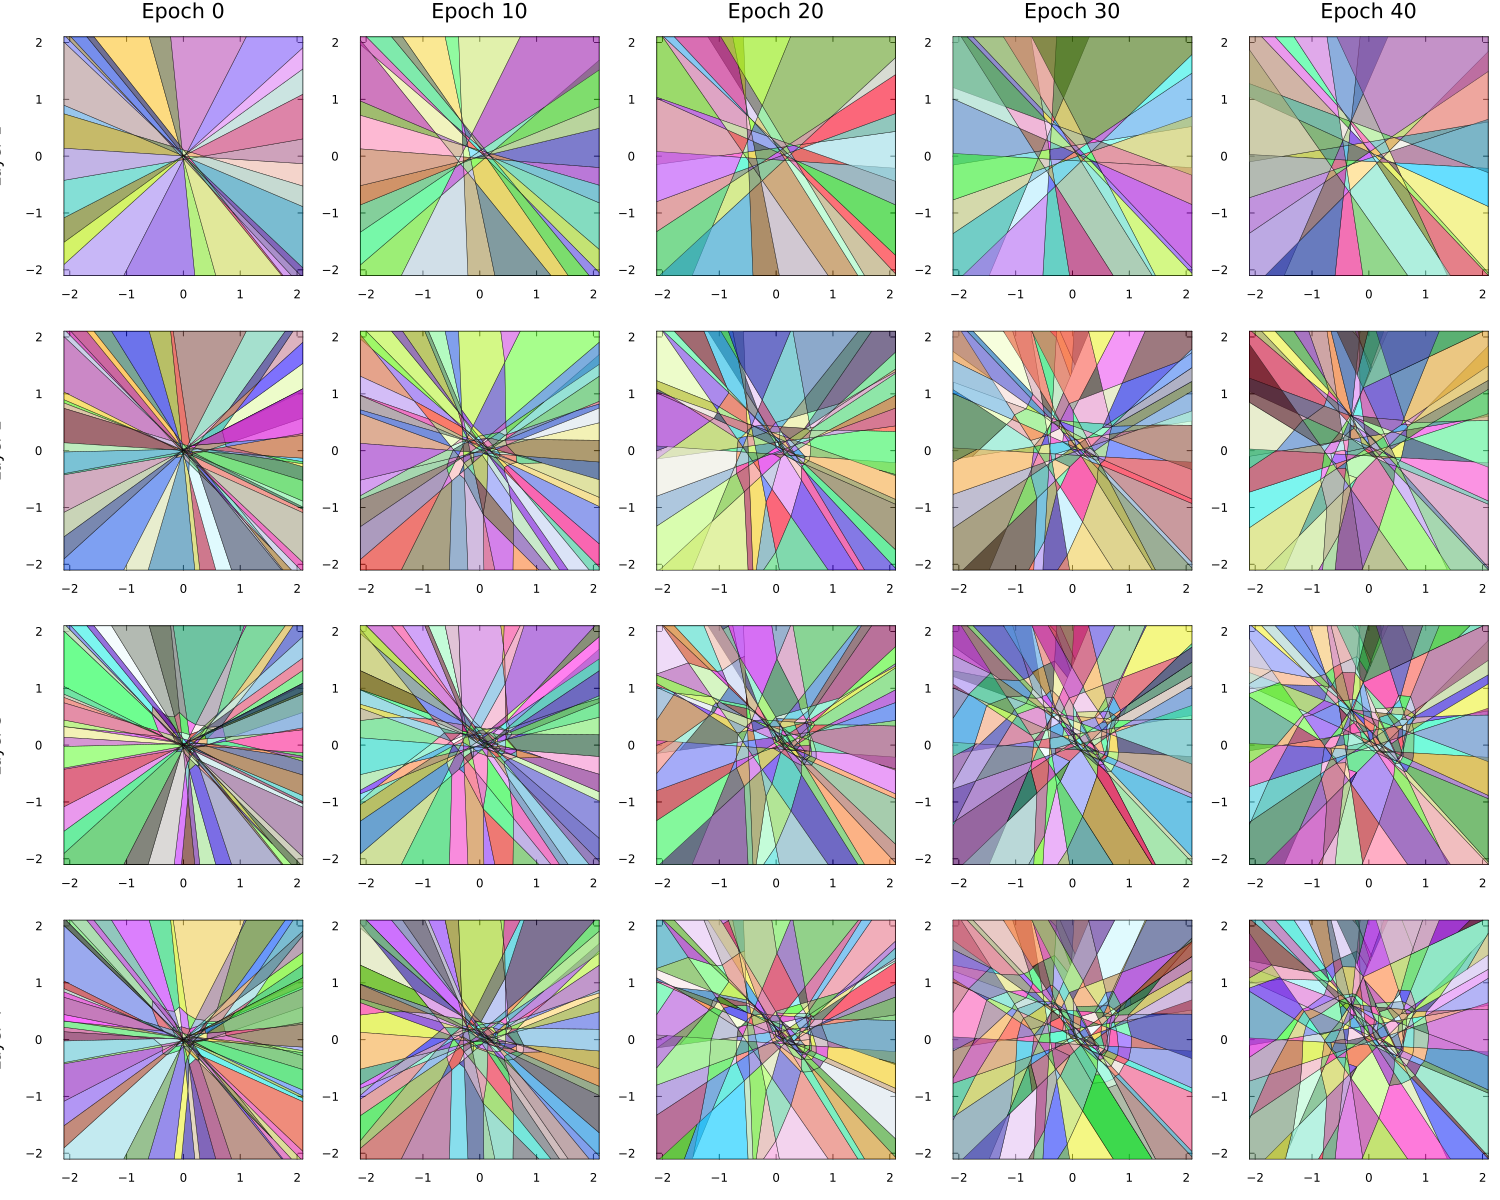

In [2]:
using Polyhedra
using CDDLib      # The backend solver (C-library)
using Plots
using Colors
using LinearAlgebra

# 1. Helper to create a bounded polyhedron from a Region
function get_bounded_polyhedron(region; bound=2000)
    # Get the inequalities from your struct: Dlw * x <= glw
    # We explicitly copy them to ensure we don't mutate the tree
    A, b = PolyhedraTree.get_path_inequalities(region)
    
    # Dimensions
    dim = size(A, 2)
    
    # Create Bounding Box Constraints: -bound <= x <= bound
    # This is equivalent to:  I*x <= bound  AND -I*x <= bound
    I_mat = Matrix{Float64}(I, dim, dim)
    
    A_box = vcat(I_mat, -I_mat)      # Stack identity and negative identity
    b_box = fill(bound, 2 * dim)     # Vector of [bound, bound, ...]
    
    # Combine Region constraints with Box constraints
    A_full = vcat(A, A_box)
    b_full = vcat(b, b_box)
    
    # Create the Polyhedron using CDDLib
    # H-representation: {x | Ax <= b}
    h = hrep(A_full, b_full)
    poly = polyhedron(h, CDDLib.Library())
    
    # Compute vertices (V-representation) to check if empty/valid
    # removevredundancy! triggers the computation of vertices
    try
        removevredundancy!(poly)
        if isempty(poly)
            return nothing
        end
        return poly
    catch e
        return nothing
    end
end

# 2. Main Plotting Function
function plot_epoch_layer_grid(trees; bound=10)
    epochs = sort(collect(keys(trees)))
    num_epochs = length(epochs)
    
    # Assume all trees have same depth
    num_layers = trees[epochs[1]].L
    
    # Setup the plot layout (Grid: Layers x Epochs)
    # layout = @layout [grid(num_layers, num_epochs)]
    
    # Initialize a large plot object with subplots
    p = plot(layout = (num_layers, num_epochs), 
             size = (num_epochs * 300, num_layers * 300),
             legend = false,
             framestyle = :box)

    for (col, epoch) in enumerate(epochs)
        tree = trees[epoch]
        
        for layer in 1:num_layers
            # Calculate subplot index (linear indexing in Julia Plots)
            # Row `layer`, Column `col`
            subplot_idx = (layer - 1) * num_epochs + col
            
            # Formatting (Titles and Labels)
            if layer == 1
                plot!(p[subplot_idx], title="Epoch $epoch")
            end
            if col == 1
                plot!(p[subplot_idx], ylabel="Layer $layer")
            end
            
            # Set limits and aspect ratio
            plot!(p[subplot_idx], 
                  xlims=(-bound, bound), 
                  ylims=(-bound, bound), 
                  aspect_ratio=:equal,
                  grid=false)

            # Get regions and plot them
            # Note: Explicitly calling PolyhedraTree module if needed
            regions = PolyhedraTree.get_regions_at_layer(tree, layer)
            
            for region in regions
                poly = get_bounded_polyhedron(region)
                
                if !isnothing(poly)
                    # Plots.jl has a recipe for Polyhedra. 
                    # It handles the triangulation/polygon creation automatically.
                    plot!(p[subplot_idx], poly, 
                          color = rand(RGB), 
                          alpha = 0.6, 
                          linecolor = :black, 
                          linewidth = 0.5)
                end
            end
        end
    end
    
    return p
end

# Usage:
plt = plot_epoch_layer_grid(trees, bound=2.1)
display(plt)
# savefig(plt, "grid_visualization.png")

In [6]:
hidden_sizes = [0, 15, 10, 5, 1]

# In Julia, cumsum works similarly but exponentiation is element-wise with .^
n_theo_all = 2 .^ cumsum(hidden_sizes)

t0 = trees[40]

for i in 1:t0.L
    # Julia is 1-indexed, so we access layer i directly
    regions_in_layer = PolyhedraTree.get_regions_at_layer(t0, i)
    n_new = length(regions_in_layer)
    
    # Access the theoretical number. Note: hidden_sizes had a 0 at index 1,
    # so index i+1 in n_theo_all corresponds to layer i.
    n_theo = n_theo_all[i + 1]
    
    println("\nLayer: $i\nRegions (new): $n_new\nRegions (tot): $n_theo\n")
end


Layer: 1
Regions (new): 104
Regions (tot): 32768


Layer: 2
Regions (new): 309
Regions (tot): 33554432


Layer: 3
Regions (new): 2709
Regions (tot): 1073741824


Layer: 4
Regions (new): 4329
Regions (tot): 2147483648

